ECE 740 FINAL PROJECT

**BRAIN TUMOUR DETECTION USING MASK R-CNN**

SAI SUHAS KUMAR PEDDAKURMA (1656691)

CLONING DATA FROM GITHUB AND INSTALLING PACKAGES.

In [ ]:
from IPython.display import clear_output
!git clone https://github.com/matterport/Mask_RCNN.git 
!git clone https://github.com/ruslan-kl/brain-tumor.git 
!pip install pycocotools
%tensorflow_version 1.x
!pip install keras==2.1.5

!rm -rf brain-tumor/.git/
!rm -rf Mask_RCNN/.git/

clear_output()

IMPORTING REQUIRED PACKAGES.

In [ ]:
import os 
import sys
from tqdm import tqdm
import cv2
import numpy as np
import json
import skimage.draw
import matplotlib
import matplotlib.pyplot as plt
import random


ROOT_DIR = os.path.abspath('Mask_RCNN/')
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn import visualize
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
import coco

plt.rcParams['figure.facecolor'] = 'white'

clear_output()

DEFINITION FOR PLOTS.

In [ ]:
def get_auxilary(rows=1, cols=1, size=7):
   
    _, auxilary = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return auxilary

CREATING DIRECTORIES.

In [ ]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs') 
DATASET_DIR = 'brain-tumor/data_cleaned/' 
DEFAULT_LOGS_DIR = 'logs' 

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

CONFIGURATION OF GPU AND SETTING LEARNING RATE.

In [ ]:
class TumorConfig(Config):
    NAME = 'tumor_detector'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + tumor
    DETECTION_MIN_CONFIDENCE = 0.85    
    STEPS_PER_EPOCH = 100
    LEARNING_RATE = 0.001
    
config = TumorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

BUILDING CUSTOM DATASET FOR THE BRAIN SCAN IMAGE DATASET.

In [ ]:
class Dataset(utils.Dataset):

    def scan(self, dataset_dir, subset):
        
        self.add_class("tumor", 1, "tumor")

        assert subset in ["train", "val", 'test']
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(DATASET_DIR, subset, 'annotations_'+subset+'.json')))
        annotations = list(annotations.values())  
        annotations = [a for a in annotations if a['regions']]

        for a in annotations:
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "tumor",
                image_id=a['filename'],  
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons
            )

    def load_mask(self, image_id):
        
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

INITIALIZING MASK R-CNN MODEL FOR TRAINING.

In [ ]:


model = modellib.MaskRCNN(
    mode='training', 
    config=config, 
    model_dir=DEFAULT_LOGS_DIR
)

model.load_weights(
    COCO_MODEL_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)

LOADING THE DATASET AND TRAINING THE MODEL.

In [ ]:

d_train = Dataset()
d_train.scan(DATASET_DIR, 'train')
d_train.prepare()

d_validation = Dataset()
d_validation.scan(DATASET_DIR, 'val')
d_validation.prepare()

d_test = Dataset()
d_test.scan(DATASET_DIR, 'test')
d_test.prepare()


print("Training network heads")
model.train(
    d_train, d_validation,
    learning_rate=config.LEARNING_RATE,
    epochs=25,
    layers='heads'
)

Training network heads

Starting at epoch 0. LR=0.001

Checkpoint Path: logs/tumor_detector20210416T2200/mask_rcnn_tumor_detector_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2087: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers 

Epoch 1/25
 99/100 [============================>.] - ETA: 0s - loss: 1.6322 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.6046 - mrcnn_class_loss: 0.0861 - mrcnn_bbox_loss: 0.6162 - mrcnn_mask_loss: 0.2937

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2330: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


100/100 [==============================] - 99s 991ms/step - loss: 1.6310 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.6044 - mrcnn_class_loss: 0.0857 - mrcnn_bbox_loss: 0.6155 - mrcnn_mask_loss: 0.2937 - val_loss: 1.3863 - val_rpn_class_loss: 0.0366 - val_rpn_bbox_loss: 0.4144 - val_mrcnn_class_loss: 0.0559 - val_mrcnn_bbox_loss: 0.5293 - val_mrcnn_mask_loss: 0.3501
Epoch 2/25
100/100 [==============================] - 74s 737ms/step - loss: 1.0189 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.2585 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.4160 - mrcnn_mask_loss: 0.2761 - val_loss: 1.4178 - val_rpn_class_loss: 0.0333 - val_rpn_bbox_loss: 0.5780 - val_mrcnn_class_loss: 0.0623 - val_mrcnn_bbox_loss: 0.4330 - val_mrcnn_mask_loss: 0.3113
Epoch 3/25
100/100 [==============================] - 76s 760ms/step - loss: 0.7885 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.2148 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.2982 - mrcnn_mask_loss: 0.2196 - val_loss: 1.6037 - val_rpn_class_loss: 

RECREATING THE MODEL.

In [ ]:

model = modellib.MaskRCNN(
    mode="inference", 
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)


model_path = model.find_last()


print("Loading:", model_path)
model.load_weights(model_path, by_name=True)

Loading: logs/tumor_detector20210416T2200/mask_rcnn_tumor_detector_0025.h5
Re-starting from epoch 25


BUILDING FUNCTIONS TO DISPLAY THE RESULTS.

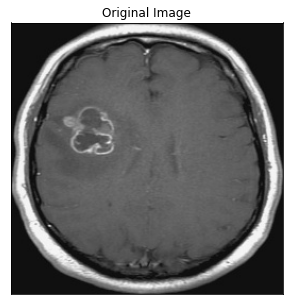

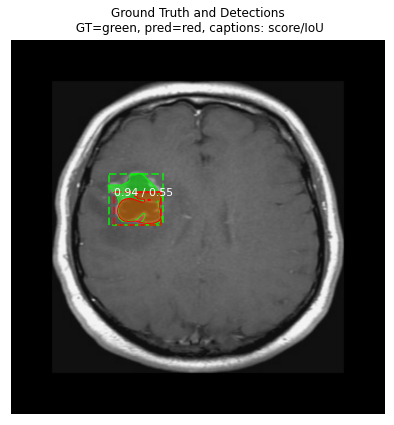

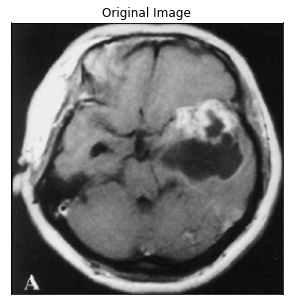

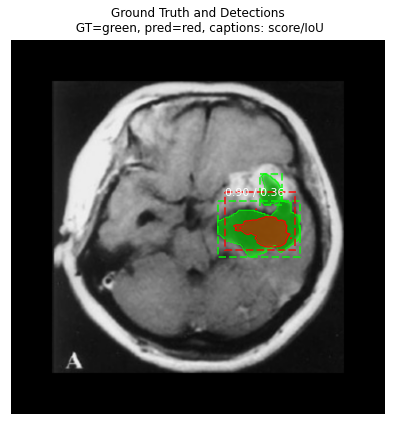

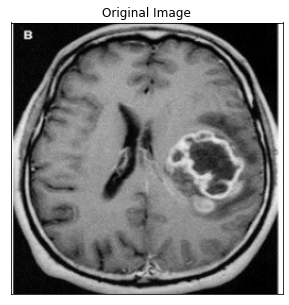

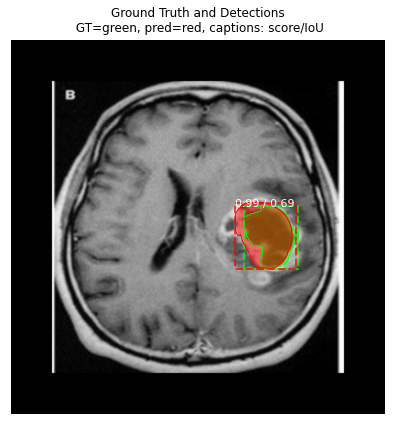

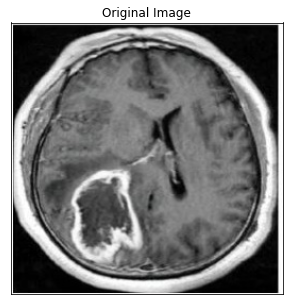

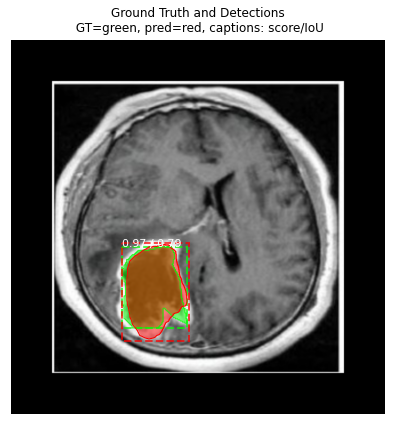

In [ ]:
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=0)
    r = results[0]

    visualize.display_differences(
        original_image,
        gt_box, gt_class_id, gt_mask,
        r['rois'], r['class_ids'], r['scores'], r['masks'],
        class_names = ['tumor'], title="", ax=get_auxilary(),
        show_mask=True, show_box=True)
    

def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()

#vALIDATION SET
index= 2
display_image(d_validation, index)
predict_and_plot_differences(d_validation, index)

index = 6
display_image(d_validation, index)
predict_and_plot_differences(d_validation, index)

#Test Set
index = 1
display_image(d_test, index)
predict_and_plot_differences(d_test, index)
index = 2
display_image(d_test, index)
predict_and_plot_differences(d_test, index)